<b><font size="5">Predicting the Probability of Catastrophe for Flight Impacts with Animals</font></b>

Birds have always been an interest of mine. I wanted to make a bird related machine learning model, and predicting bird species by bird call or image is too obvious. Here, I predict the probability of catastrophe for flight impacts with animals, almost all of which are birds. More specifically, I predict the chance of aircraft damage, injury, and death. The models take aircraft type, animal species, animal quantity, impact location, elevation, and speed of impact into account.

Enjoy the impact statistics and data visualizations. Over 650,000 animals were harmed in the making of these models.

<b>Summary of Steps:</b>
1. Group birds taxonomically
1. Add a column for species weight
1. Generate statics and visualizations
1. Generate models for aircraft damage, injury, and fatality
1. Build a tool to help choose model input values
1. Compare chance of aircraft damage, injury, and fatality by impact location on aircraft
1. Predict chance of aircraft damage, injury, and fatality for a custom list of impact locations

<b>Model Accuracies:</b>
- Aircraft Damage: 0.900210
- Injuries: 0.998289
- Fatalies: 1.000000

<b>Occurace Rates:</b>
- No Aircraft Damage: 0.874337
- No Injuries: 0.997729
- No Fatalies: 0.999922


In [8]:
### Imports

import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
import matplotlib
import pandas as pd
import seaborn as sns
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from datetime import date
import calendar

In [9]:
### Variables

backgroundColor = '#444444'
impColor = 'skyblue'
dmgColor = 'yellow'
injColor = 'orange'
fatColor = 'red'
legendColor = 'w'
DPI = 300
titleSize = 36
axisLabelSize = 30
tickLabelSize = 22
legendTextSize = 18
standardCanvasHeight = 11
standardCanvasWidth = 20
predictionCols = ['Aircraft Damage', 'Injuries', 'Fatalities']
strikeLocations = ['Engine Strike', 'Fuselage Strike', 'Landing Gear Strike', 'Lights Strike', 'Nose Strike',
                   'Propeller Strike', 'Radome Strike', 'Tail Strike','Windshield Strike',
                   'Wing or Rotor Strike', 'Other Strike']
animalWeights = { # In kg
    'GULL': 0.935,
    'DEER': 110.0,
    'PIGEON': 0.141,
    'SPARROW': 0.03,
    'VULTURE': 1.5,
    'DUCK': 1.125,
    'HAWK': 1.145,
    'STARLING': 0.079,
    'GRACKLE': 0.108,
    'GOOSE': 4.0,
    'OWL': 2.019,
    'SWALLOW': 0.019,
    'HERON': 1.5,
    'EAGLE': 4.61,
    'ANHINGA': 1.2,
    'RAIL': 0.288,
    'GREBE': 0.91,
    'OSPREY': 1.4,
    'SWIFT': 0.038,
    'FRIGATEBIRD': 1.361,
    'CRANE': 4.6,
    'CORMORANT': 2.675,
    'BAT': 0.033,
    'WARBLER': 0.01,
    'PLOVER': 0.049,
    'IBIS': 1.045,
    'FINCH': 0.022,
    'TROPICBIRD': 0.8,
    'TURKEY': 6.75,
    'SANDPIPER': 0.04,
    'ROBIN': 0.077,    
    'PELICAN': 6.1, 
    'CROW': 0.5, 
    'LARK': 0.031,
    'COW': 910.0,
    'UNKSBRD': 0.079, # Same as STARLING
    'UNKMBRD': 0.935, # Same as GULL
    'UNKLBRD': 4.0, # Same as GOOSE
}

In [10]:
### Setting Up Dataframe

# Used to merge the 4 engine strike columns together, 1 if any engines are struck, 0 otherwise.
def hasEngineStrike(row):
    return int(row['Engine1 Strike']==1 or row['Engine2 Strike']==1 
               or row['Engine3 Strike']==1 or row['Engine4 Strike']==1)

# Renames one or more animals species to have a common name. Used to group birds taxonomically.
def renameBirdGroup(df, keys, name):
    for key in keys:
        df.loc[(df['Species Name'].str.contains(key)), 'Species Name'] = name

# I only care if there are injuries, not how many. I assume there is injury if there is death.
def hasInjuries(row):
    return int(row['Injuries'] > 0 or row['Fatalities'] == 1)

# I assume there is aircraft damage if there is injury or death 
def hasDamage(row):
    return int(row['Aircraft Damage'] == 1 or row['Injuries'] == 1 or row['Fatalities'] == 1)

# Most conservative estimates
def getQuantity(row):
    numAnimals = row['Species Quantity']
    if numAnimals == '1':     
        return 1
    elif numAnimals == '2-10':
        return 2
    elif numAnimals == '11-100':
        return 11
    else:
        return 101

# Importing raw data
dataTypes = {'Species Quantity': 'str', 'Aircraft Mass': 'str', 'Engine Make': 'str'}
impacts = pd.read_csv('database.csv', dtype=dataTypes, low_memory=False)

# Removing/filling null values
impacts = impacts[impacts['Height'].notnull()]
impacts = impacts[impacts['Speed'].notnull()]
impacts = impacts[impacts['Species Name'].notnull()]
impacts = impacts[impacts['Species Quantity'].notnull()]
impacts = impacts[impacts['Engines'].notnull()]
impacts = impacts[impacts['Aircraft Mass'].notnull()]
impacts['Aircraft Make'] = impacts['Aircraft Make'].fillna('UNKNOWN')
impacts['Aircraft Model'] = impacts['Aircraft Model'].fillna('UNKNOWN')

# Modifying cols
impacts['Height'] = impacts['Height'].divide(3.28084) # feet to m
impacts['Speed'] = impacts['Speed'].multiply(1.852) # knots to km/h
impacts['Engine Strike'] = impacts.apply(lambda row: hasEngineStrike(row), axis=1)
impacts['Species Name'] = impacts['Species Name'].str.upper()
impacts['Fatalities'] = impacts.apply(lambda row: int(row['Fatalities'] > 0), axis=1) # 1 if any, 0 otherwise
impacts['Injuries'] = impacts.apply(lambda row: hasInjuries(row), axis=1) # 1 if any, 0 otherwise
impacts['Aircraft Damage'] = impacts.apply(lambda row: hasDamage(row), axis=1)
impacts['Aircraft Type'] = impacts.apply(lambda row: int(row['Aircraft Type'] == 'B'), axis=1) # 1 if heli, 0 if plane
impacts['Species Quantity'] = impacts.apply(lambda row: getQuantity(row), axis=1)
impacts['Date'] = pd.to_datetime(dict(year=impacts['Incident Year'], 
                                    month=impacts['Incident Month'], 
                                    day=impacts['Incident Day'])).dt.date

# Removing unneeded cols
impacts = impacts.drop(['Record ID', 'Airport ID', 'Operator ID', 'Operator', 'Airport',
                        'State', 'FAA Region', 'Warning Issued', 'Radome Damage', 'Flight Impact', 'Flight Phase', 
                        'Windshield Damage', 'Nose Damage', 'Engine4 Position', 'Engine1 Damage', 'Engine2 Damage', 
                        'Engine1 Strike', 'Engine3 Damage', 'Engine4 Damage', 'Engine4 Strike', 'Engine Ingested', 
                        'Propeller Damage', 'Distance', 'Wing or Rotor Damage', 'Engine3 Strike', 'Species ID', 
                        'Fuselage Damage', 'Landing Gear Damage', 'Engine2 Strike', 'Tail Damage', 'Lights Damage', 
                        'Visibility', 'Other Damage', 'Flight Phase', 'Precipitation', 'Engine Ingested', 
                        'Engine1 Position', 'Engine2 Position', 'Engine3 Position', 'Incident Year', 
                        'Incident Month', 'Incident Day'], axis = 1)

# Grouping and renaming animals
renameBirdGroup(impacts, ['VULTURE'], 'VULTURE')
renameBirdGroup(impacts, ['GOOSE', 'GEESE', 'BRANT'], 'GOOSE')
renameBirdGroup(impacts, ['GULL'], 'GULL')
renameBirdGroup(impacts, ['DEER', 'MOOSE', 'ELK', 'PRONGHORN', 'HORSE'], 'DEER')
renameBirdGroup(impacts, ['HAWK', 'HARRIER', 'KESTREL'], 'HAWK')
renameBirdGroup(impacts, ['DOVE', 'PIGEON'], 'PIGEON')
renameBirdGroup(impacts, ['EAGLE'], 'EAGLE')
renameBirdGroup(impacts, ['OWL'], 'OWL')
renameBirdGroup(impacts, ['HERON', 'BITTERN', 'EGRET'], 'HERON')
renameBirdGroup(impacts, ['CRANE'], 'CRANE')
renameBirdGroup(impacts, ['SPARROW', 'JUNCO', 'LONGSPUR'], 'SPARROW')
renameBirdGroup(impacts, ['STARLING', 'MYNA'], 'STARLING')
renameBirdGroup(impacts, ['SWALLOW', 'MARTIN'], 'SWALLOW')
renameBirdGroup(impacts, ['LOON'], 'LOON')
renameBirdGroup(impacts, ['BLACKBIRD', 'COWBIRD', 'ORIOLE', 'GRACKLE'], 'GRACKLE')
renameBirdGroup(impacts, ['LARK'], 'LARK')
renameBirdGroup(impacts, ['ROBIN', 'THRUSH'], 'ROBIN')
renameBirdGroup(impacts, ['PLOVER', 'LAPWING'], 'PLOVER')
renameBirdGroup(impacts, ['SWIFT'], 'SWIFT')
renameBirdGroup(impacts, ['CROW', 'RAVEN'], 'CROW')
renameBirdGroup(impacts, ['UNKNOWN LARGE BIRD'], 'UNK L BRD')
renameBirdGroup(impacts, ['UNKNOWN MEDIUM BIRD', 'UNKNOWN BIRD', 'SHOREBIRD'], 'UNK M BRD')
renameBirdGroup(impacts, ['UNKNOWN SMALL BIRD', 'PERCHING BIRDS'], 'UNK S BRD')
renameBirdGroup(impacts, ['MAGPIE'], 'MAGPIE')
renameBirdGroup(impacts, ['BUNTING'], 'BUNTING')
renameBirdGroup(impacts, ['CATTLE'], 'COW')
renameBirdGroup(impacts, ['WAXWING'], 'WAXWING')
renameBirdGroup(impacts, ['FALCON', 'MERLIN', 'CARACARA'], 'FALCON')
renameBirdGroup(impacts, ['WARBLER', 'YELLOWTHROAT', 'REDSTART', 'OVENBIRD'], 'WARBLER')
renameBirdGroup(impacts, ['COOT', 'RAIL', 'SORA', 'MOORHEN', 'GALLINULE'], 'RAIL')
renameBirdGroup(impacts, ['CORMORANT'], 'CORMORANT')
renameBirdGroup(impacts, ['GREBE'], 'GREBE')
renameBirdGroup(impacts, ['FRIGATEBIRD'], 'FRIGATEBIRD')
renameBirdGroup(impacts, ['IBIS'], 'IBIS')
renameBirdGroup(impacts, ['TROPICBIRD'], 'TROPICBIRD')
renameBirdGroup(impacts, ['PELICAN'], 'PELICAN')
renameBirdGroup(impacts, ['PHEASANT', 'TURKEY', 'GROUSE', 'PARTRIDGE', 'PTARMIGAN'], 'TURKEY')
renameBirdGroup(impacts, ['SWAN'], 'SWAN')
renameBirdGroup(impacts, ['FINCH', 'MUNIA', 'GROSBEAK'], 'FINCH')
renameBirdGroup(impacts, ['CATBIRD'], 'CATBIRD')
renameBirdGroup(impacts, ['RABBIT', 'COTTONTAIL', 'HARE'], 'RABBIT')
renameBirdGroup(impacts, ['SKUNK'], 'SKUNK')
renameBirdGroup(impacts, ['KINGBIRD'], 'KINGBIRD')
renameBirdGroup(impacts, ['PIPIT'], 'PIPIT')
renameBirdGroup(impacts, ['FLYCATCHER'], 'FLYCATCHER')
renameBirdGroup(impacts, ['PIPIT'], 'PIPIT')
renameBirdGroup(impacts, ['TERN'], 'TERN')
renameBirdGroup(impacts, ['OPOSSUM'], 'OPOSSUM')
renameBirdGroup(impacts, ['FOX'], 'FOX')
renameBirdGroup(impacts, ['VIREO'], 'VIREO')
renameBirdGroup(impacts, ['FLICKER', 'WOODPECKER', 'SAPSUCKER'], 'WOODPECKER')
renameBirdGroup(impacts, ['WOODCOCK'], 'WOODCOCK')
renameBirdGroup(impacts, ['SNIPE'], 'SNIPE')
renameBirdGroup(impacts, ['KITE'], 'KITE')
renameBirdGroup(impacts, ['CUCKOO'], 'CUCKOO')
renameBirdGroup(impacts, ['STORK'], 'STORK')
renameBirdGroup(impacts, ['TURTLE', 'TERRAPIN'], 'TURTLE')
renameBirdGroup(impacts, ['TANAGER'], 'TANAGER')
renameBirdGroup(impacts, ['CHICKADEE'], 'CHICKADEE')
renameBirdGroup(impacts, ['QUAIL', 'BOBWHITE'], 'QUAIL')
renameBirdGroup(impacts, ['DUNLIN', 'STINT'], 'STINT')
renameBirdGroup(impacts, ['DOG', 'CANIDS'], 'DOG')
renameBirdGroup(impacts, ['BAT', 'MYOTIS'], 'BAT')
renameBirdGroup(impacts, ['CURLEW'], 'CURLEW')
renameBirdGroup(impacts, ['WREN'], 'WREN')
renameBirdGroup(impacts, ['SANDPIPER', 'SANDERLING', 'WHIMBREL', 'DOWITCHER', 'GODWIT',
                          'PHALAROPE', 'DUNLIN', 'STINT'], 'SANDPIPER')
renameBirdGroup(impacts, ['MALLARD', 'DUCK', 'PINTAIL', 'WIGEON', 'SHOVELER', 'MERGANSER', 'GOLDENEYE', 'EIDER',
                          'TEAL', 'GADWALL', 'CANVASBACK', 'SCAUP', 'REDHEAD', 'BUFFLEHEAD', 'SCOTER'], 'DUCK')

# Collecting the top 'nInclude' animals to not cause damage, cause injury, and cause death
nInclude = 25

impactsNoDmg = impacts[impacts['Aircraft Damage'] == 0]
animalsToInclude = impactsNoDmg['Species Name'].value_counts().nlargest(nInclude).index.tolist()

impactsDmg = impacts[impacts['Aircraft Damage'] == 1]
animalsToInclude += impactsDmg['Species Name'].value_counts().nlargest(nInclude).index.tolist()

impactsInj = impacts[impacts['Injuries'] == 1]
animalsToInclude += impactsInj['Species Name'].value_counts().nlargest(nInclude).index.tolist()

impactsFat = impacts[impacts['Fatalities'] == 1]
animalsToInclude += impactsFat['Species Name'].value_counts().nlargest(nInclude).index.tolist()

# Only keep top animals. I can't be bothered to average the weights for hundreds of species.
impacts = impacts[impacts['Species Name'].isin(animalsToInclude)]

# Adding cols
impacts['Species Weight'] = impacts['Species Name'].apply(lambda row: animalWeights[str(row.replace(' ', ''))])    

# Reording cols
impacts = impacts[['Date', 'Height', 'Speed', 'Aircraft', 'Aircraft Type', 'Aircraft Make', 'Aircraft Model', 
                   'Aircraft Mass', 'Engines', 'Engine Type', 'Engine Make', 'Engine Model', 'Species Name', 
                   'Species Quantity', 'Species Weight'] + strikeLocations + predictionCols]

# Variables for later
nImpacts = len(impacts)
XCols = ['Aircraft', 'Aircraft Mass', 'Aircraft Type', 'Aircraft Make', 'Aircraft Model', 'Engines', 
         'Species Quantity', 'Species Weight', 'Height', 'Speed'] + strikeLocations

# Catagorical column encoding
one_hot = OneHotEncoder(categories=[
    impacts['Aircraft'].unique(),
    impacts['Aircraft Mass'].unique(),
    impacts['Aircraft Make'].unique(),
    impacts['Aircraft Model'].unique()
], sparse=False)
transformer = ColumnTransformer([('one_hot', one_hot,
                                ['Aircraft', 'Aircraft Mass', 'Aircraft Make', 'Aircraft Model'])],
                                remainder='passthrough')
impactsX_t = transformer.fit_transform(impacts[XCols])

In [11]:
### Quick Statistics

print(f"Date Range Start: {impacts.Date.min()}")
print(f"Date Range End: {impacts.Date.max()}\n")

print(f"Number of Impacts: {nImpacts}")
print(f"Number of Damaged Aircrafts: {int(impacts['Aircraft Damage'].sum())}")
print(f"Number of Injuries: {int(impacts['Injuries'].sum())}")
print(f"Number of Fatalities: {int(impacts['Fatalities'].sum())}\n")

print(f"Damaged Aircraft Rate: {round(impacts['Aircraft Damage'].sum()/nImpacts, 2)}")
print(f"Injury Rate: {round(impacts['Injuries'].sum()/nImpacts, 4)}")
print(f"Fatality Rate: {'%f' % round(impacts['Fatalities'].sum()/nImpacts, 6)}\n")

print(f"Runway Impact Rate: {round((len(impacts[impacts['Height'] == 0])/nImpacts), 2)}")
impactsKnownAnimal = impacts[~impacts['Species Name'].str.contains('UNK')]
print(f"Unknown Animal Rate: {round(1-(len(impactsKnownAnimal)/nImpacts), 2)}")
print(f"Helicopter-Airplane Ratio: {round(impacts['Aircraft Type'].sum()/nImpacts, 3)}")
print(f"Average Animal Qantity: {round(impacts['Species Quantity'].sum()/nImpacts, 1)}\n")

print('Impact Location Rates:')
round(impacts[strikeLocations].mean().sort_values(ascending=False), 2)

Date Range Start: 1990-01-03
Date Range End: 2015-09-30

Number of Impacts: 64283
Number of Damaged Aircrafts: 8078
Number of Injuries: 146
Number of Fatalities: 5

Damaged Aircraft Rate: 0.13
Injury Rate: 0.0023
Fatality Rate: 0.000078

Runway Impact Rate: 0.27
Unknown Animal Rate: 0.61
Helicopter-Airplane Ratio: 0.024
Average Animal Qantity: 1.3

Impact Location Rates:


Windshield Strike       0.24
Nose Strike             0.20
Radome Strike           0.18
Fuselage Strike         0.16
Wing or Rotor Strike    0.15
Engine Strike           0.12
Landing Gear Strike     0.06
Other Strike            0.05
Propeller Strike        0.03
Tail Strike             0.02
Lights Strike           0.01
dtype: float64

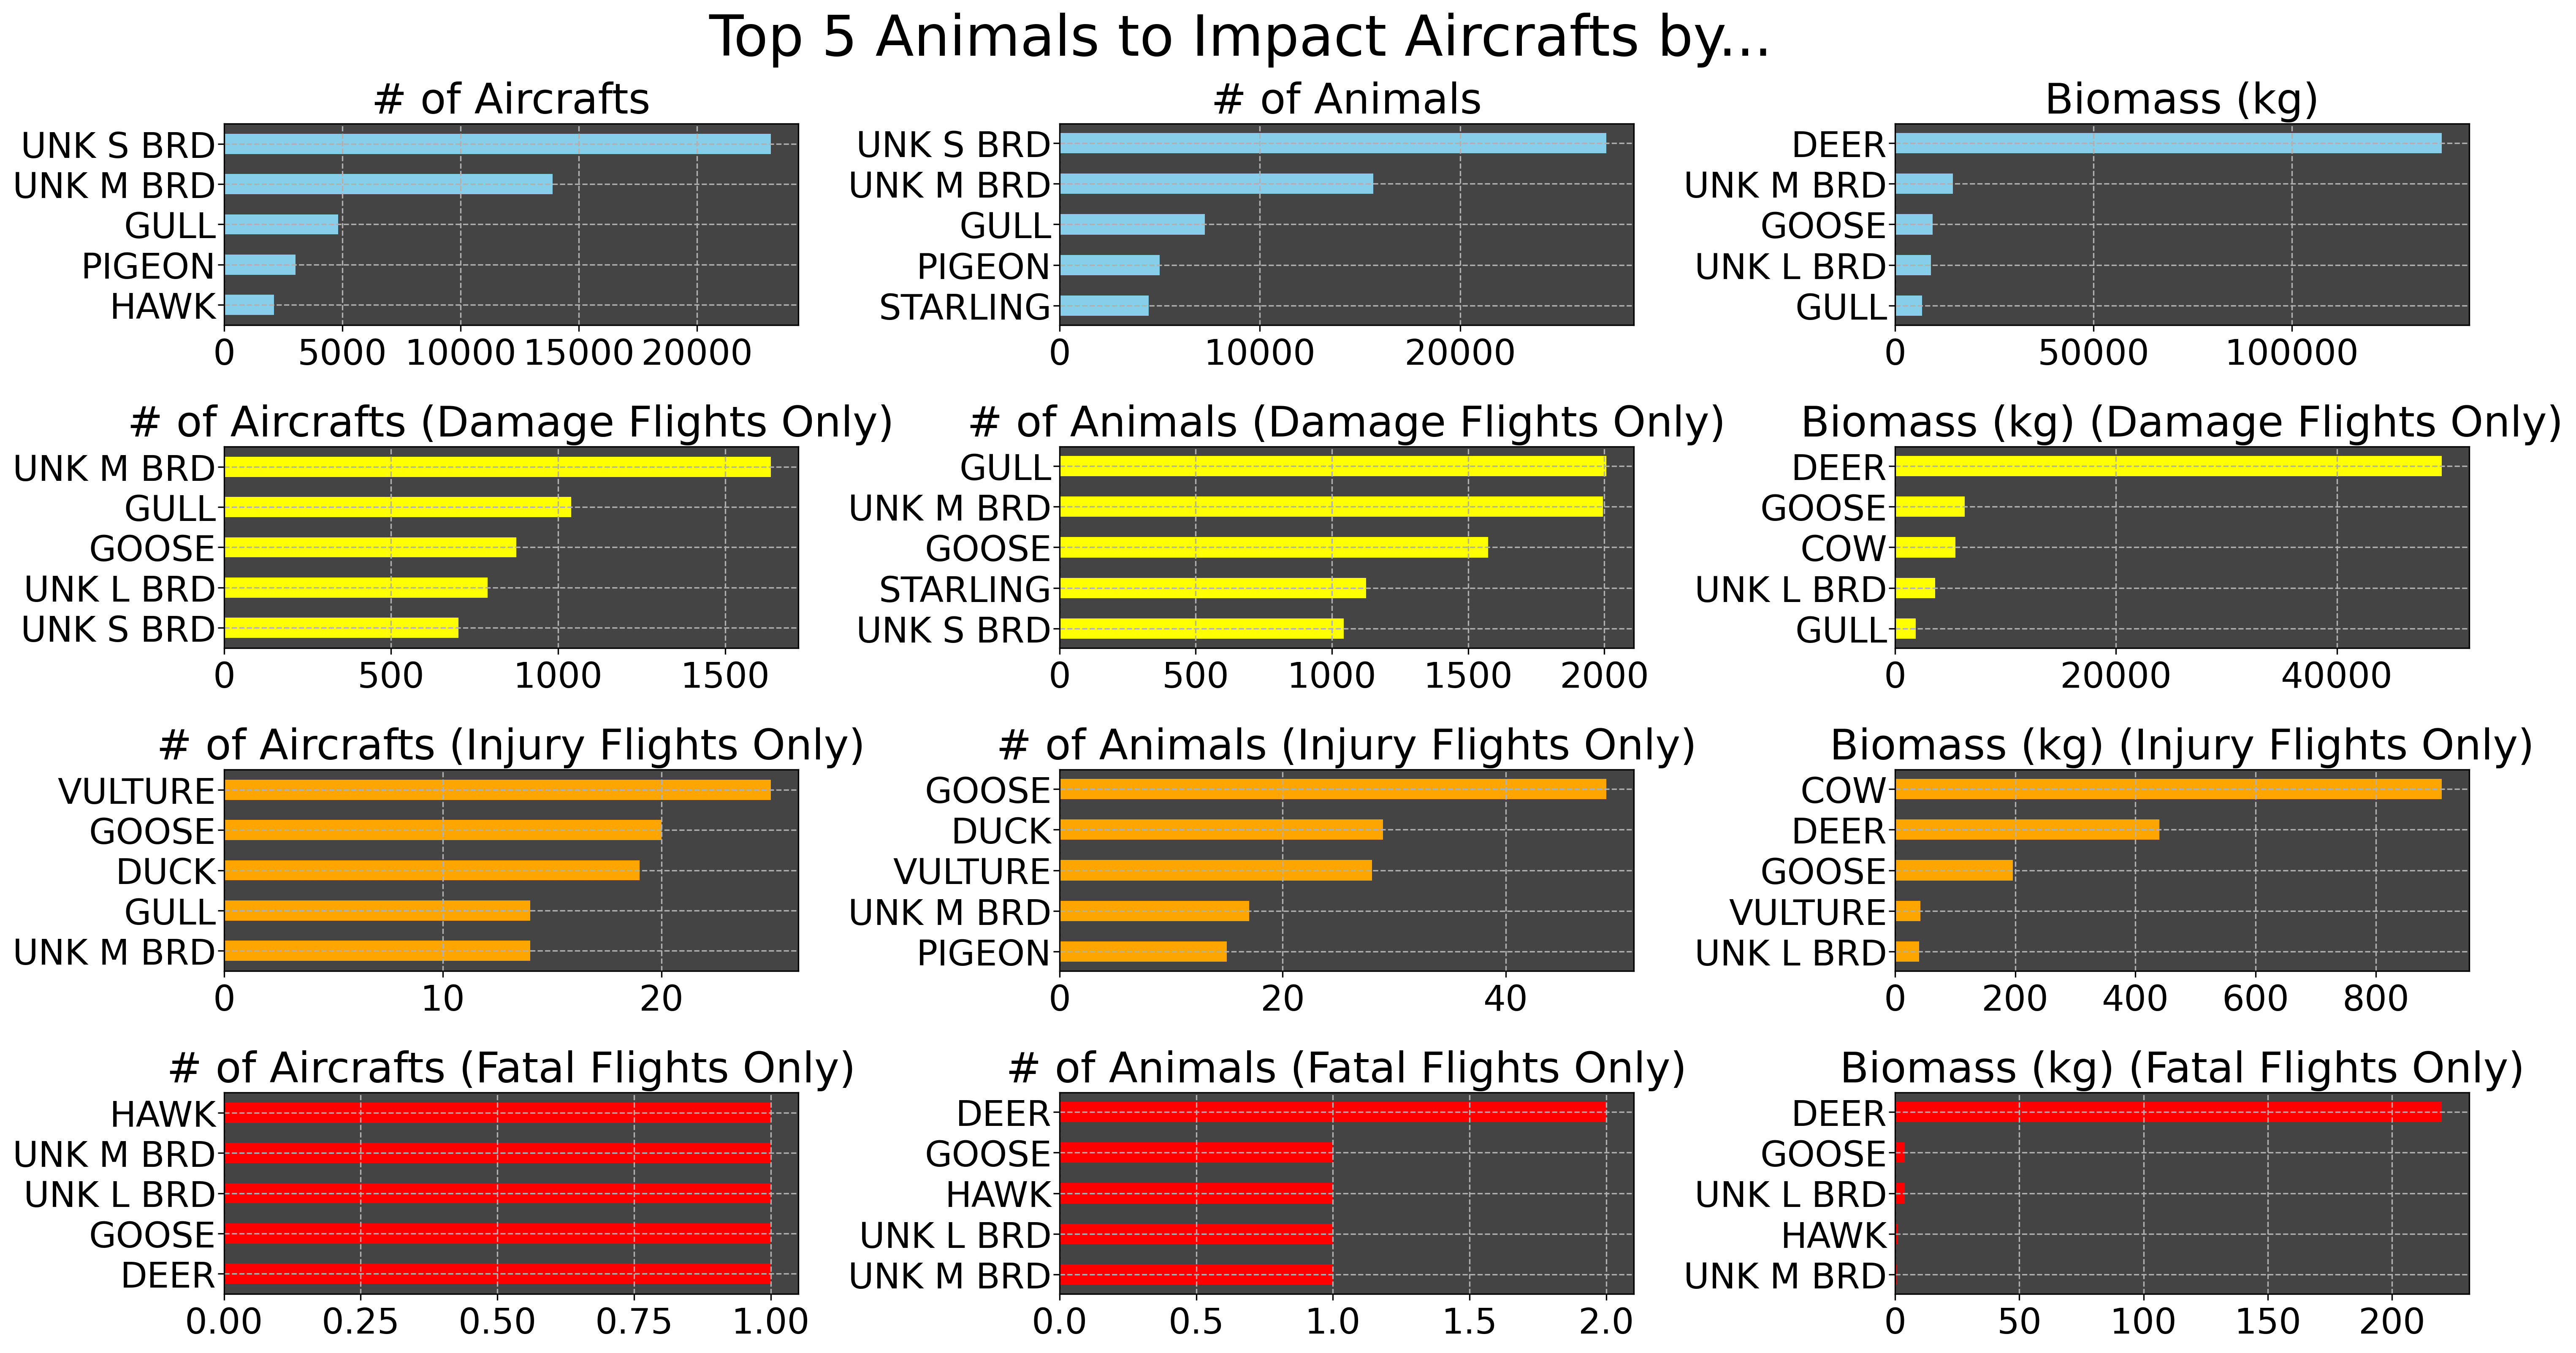

In [13]:
###  Comparing the Top Animals

def getBioMass(row):
    return row['Species Quantity'] * row['Species Weight']

# Number of animals to show per plot
numAnimals = 5

impactsDmg = impacts[impacts['Aircraft Damage'] == 1].copy()
impactsInj = impacts[impacts['Injuries'] == 1].copy()
impactsFat = impacts[impacts['Fatalities'] == 1].copy()

impacts['Biomass'] = impacts.apply(lambda row: getBioMass(row), axis=1)
animalsGrouped = impacts[['Species Name', 'Biomass', 'Species Quantity']].groupby(['Species Name']).sum()
namesAndQuantity = animalsGrouped.sort_values('Species Quantity').nlargest(numAnimals, ['Species Quantity'])
namesAndBiomass = animalsGrouped.sort_values('Biomass').nlargest(numAnimals, ['Biomass'])

impactsDmg['Biomass'] = impactsDmg.apply(lambda row: getBioMass(row), axis=1)
animalsGroupedDmg = impactsDmg[['Species Name', 'Biomass', 'Species Quantity']].groupby(['Species Name']).sum()
namesAndQuantityDmg = animalsGroupedDmg.sort_values('Species Quantity').nlargest(numAnimals, ['Species Quantity'])
namesAndBiomassDmg = animalsGroupedDmg.sort_values('Biomass').nlargest(numAnimals, ['Biomass'])

impactsInj['Biomass'] = impactsInj.apply(lambda row: getBioMass(row), axis=1)
animalsGroupedInj = impactsInj[['Species Name', 'Biomass', 'Species Quantity']].groupby(['Species Name']).sum()
namesAndQuantityInj = animalsGroupedInj.sort_values('Species Quantity').nlargest(numAnimals, ['Species Quantity'])
namesAndBiomassInj = animalsGroupedInj.sort_values('Biomass').nlargest(numAnimals, ['Biomass'])

impactsFat['Biomass'] = impactsFat.apply(lambda row: getBioMass(row), axis=1)
animalsGroupedFat = impactsFat[['Species Name', 'Biomass', 'Species Quantity']].groupby(['Species Name']).sum()
namesAndQuantityFat = animalsGroupedFat.sort_values('Species Quantity').nlargest(numAnimals, ['Species Quantity'])
namesAndBiomassFat = animalsGroupedFat.sort_values('Biomass').nlargest(numAnimals, ['Biomass'])

matplotlib.rc('font', size=20)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(nrows=4, ncols=3)

impTop = impacts['Species Name'].value_counts()[:numAnimals]
impTop.plot(ax=ax1, kind='barh', title='# of Aircrafts', color=impColor, ylabel='Species Name')

dmgTop = impacts[['Species Name', 'Aircraft Damage']]
dmgTop = dmgTop.groupby(by='Species Name')['Aircraft Damage'].sum().sort_values(ascending = False)[:numAnimals]
dmgTop.plot(ax=ax4, kind='barh', title='# of Aircrafts (Damage Flights Only)', color=dmgColor)

injTop = impacts[['Species Name', 'Injuries']]
injTop = injTop.groupby(by='Species Name')['Injuries'].sum().sort_values(ascending = False)[:numAnimals]
injTop.plot(ax=ax7, kind='barh', title='# of Aircrafts (Injury Flights Only)', color=injColor)

fatTop = impacts[['Species Name', 'Fatalities']]
fatTop = fatTop.groupby(by='Species Name')['Fatalities'].sum().sort_values(ascending = False)[:numAnimals]
fatTop.plot(ax=ax10, kind='barh', title='# of Aircrafts (Fatal Flights Only)', color=fatColor)

ax2.set_title('# of Animals')
ax2.barh(namesAndQuantity.index, namesAndQuantity['Species Quantity'], color=impColor, height=0.5)

ax5.set_title('# of Animals (Damage Flights Only)')
ax5.barh(namesAndQuantityDmg.index, namesAndQuantityDmg['Species Quantity'], color=dmgColor, height=0.5)

ax8.set_title('# of Animals (Injury Flights Only)')
ax8.barh(namesAndQuantityInj.index, namesAndQuantityInj['Species Quantity'], color=injColor, height=0.5)

ax11.set_title('# of Animals (Fatal Flights Only)')
ax11.barh(namesAndQuantityFat.index, namesAndQuantityFat['Species Quantity'], color=fatColor, height=0.5)

ax3.set_title('Biomass (kg)')
ax3.barh(namesAndBiomass.index, namesAndBiomass['Biomass'], color=impColor, height=0.5)

ax6.set_title('Biomass (kg) (Damage Flights Only)')
ax6.barh(namesAndBiomassDmg.index, namesAndBiomassDmg['Biomass'], color=dmgColor, height=0.5)

ax9.set_title('Biomass (kg) (Injury Flights Only)')
ax9.barh(namesAndBiomassInj.index, namesAndBiomassInj['Biomass'], color=injColor, height=0.5)

ax12.set_title('Biomass (kg) (Fatal Flights Only)')
ax12.barh(namesAndBiomassFat.index, namesAndBiomassFat['Biomass'], color=fatColor, height=0.5)

for a in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
    a.set_ylabel('')
    a.tick_params(axis='y', which='major', pad=1)
    a.grid(axis='both', which='major', linestyle='--')
    a.invert_yaxis()

plt.rcParams['axes.facecolor'] = backgroundColor
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle(f"Top {numAnimals} Animals to Impact Aircrafts by...", fontsize=32)
fig.patch.set_facecolor('w')
fig.set_dpi(DPI)
plt.show()

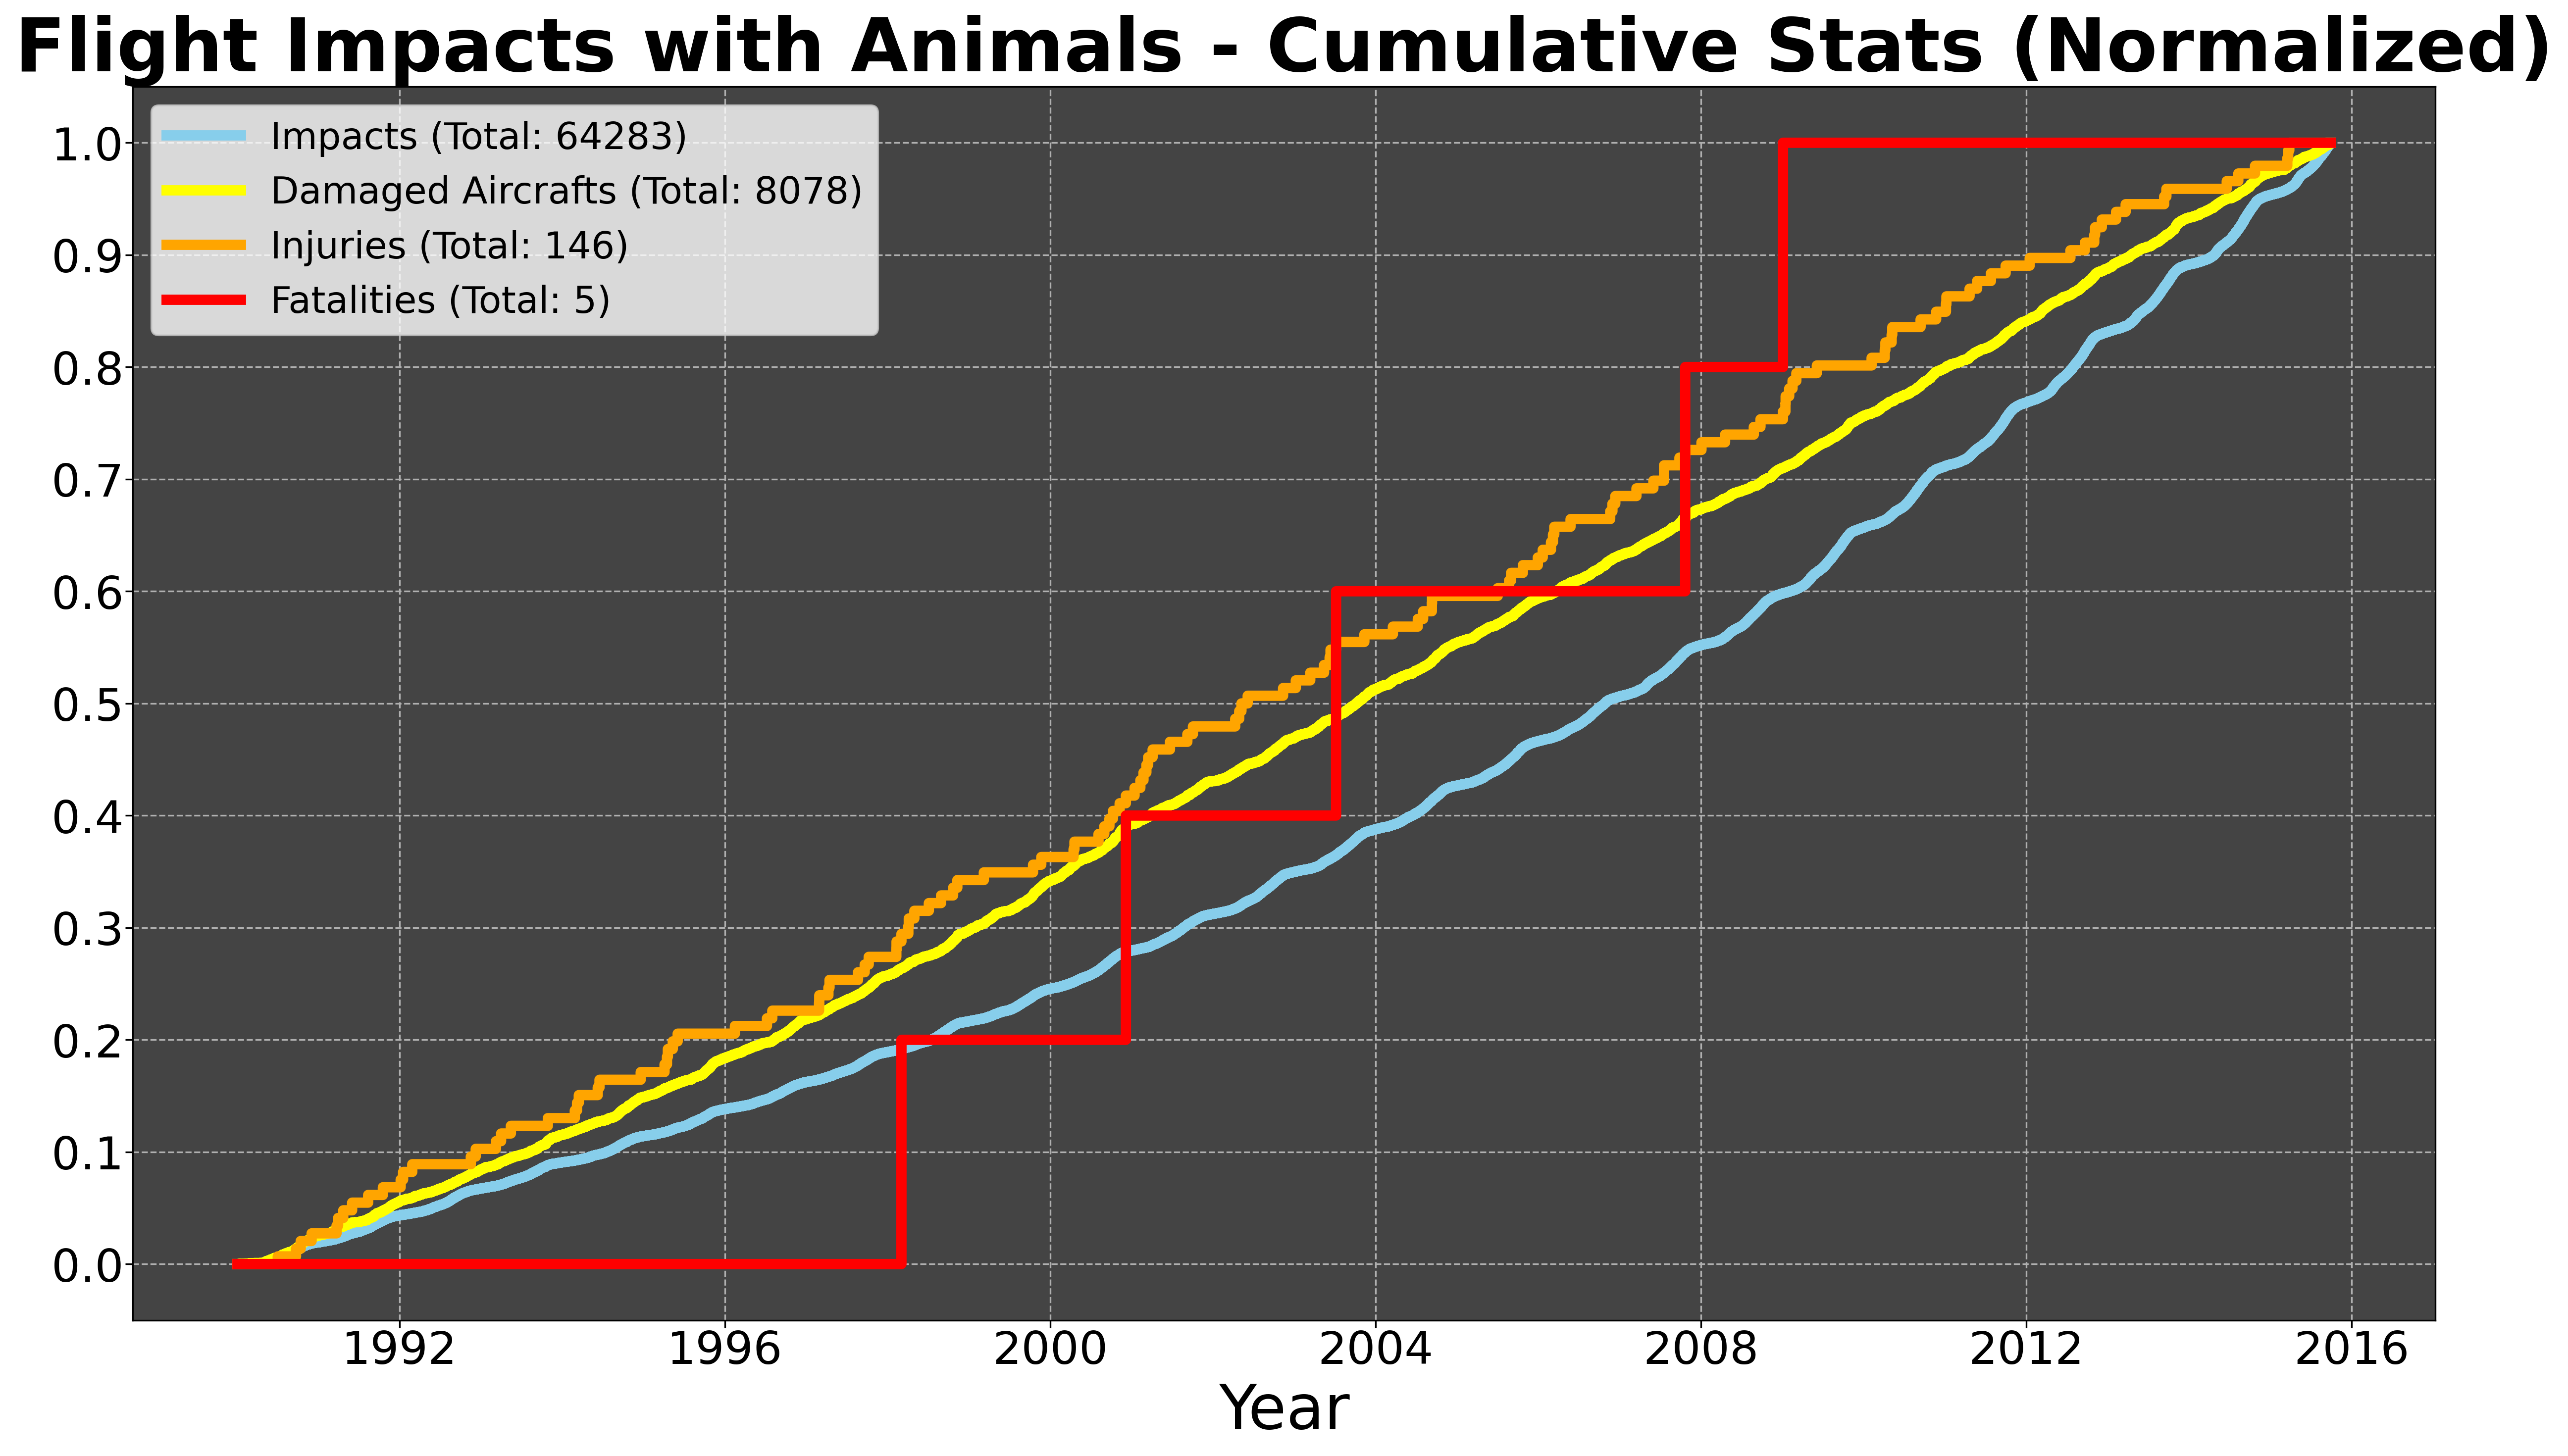

In [14]:
### Cumulative Stats Plot

# Cumulative sums
impCum = np.arange(1, nImpacts + 1)
dmgCum = impacts['Aircraft Damage'].cumsum()
injCum = impacts['Injuries'].cumsum()
fatCum = impacts['Fatalities'].cumsum()

# Legend labels
impLabel = f"Impacts (Total: {impCum.max()})"
dmgLabel = f"Damaged Aircrafts (Total: {dmgCum.max()})"
injLabel = f"Injuries (Total: {injCum.max()})"
fatLabel = f"Fatalities (Total: {fatCum.max()})"

# Plotting
ax = plt.gca()
fig = plt.gcf()
ax.set_title("Flight Impacts with Animals - Cumulative Stats (Normalized)", size=titleSize, fontweight="bold")
plt.step(impacts['Date'], impCum/impCum.max(), label=impLabel, linewidth=5, color=impColor)
plt.step(impacts['Date'], dmgCum/dmgCum.max(), label=dmgLabel, linewidth=5, color=dmgColor)
plt.step(impacts['Date'], injCum/injCum.max(), label=injLabel, linewidth=5, color=injColor)
plt.step(impacts['Date'], fatCum/fatCum.max(), label=fatLabel, linewidth=5, color=fatColor)
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.rcParams['axes.facecolor'] = backgroundColor
plt.grid(axis="both", which="both", linestyle= '--', zorder=-1)
plt.legend(facecolor=legendColor, prop={'size': legendTextSize})
plt.locator_params(axis='y', nbins=11)
plt.xlabel("Year", size=axisLabelSize)
plt.rcParams['axes.facecolor'] = backgroundColor
ax.tick_params(axis='both', which='major', pad=1, labelsize=tickLabelSize)
fig.patch.set_facecolor('w')
fig.set_dpi(DPI)
plt.show()

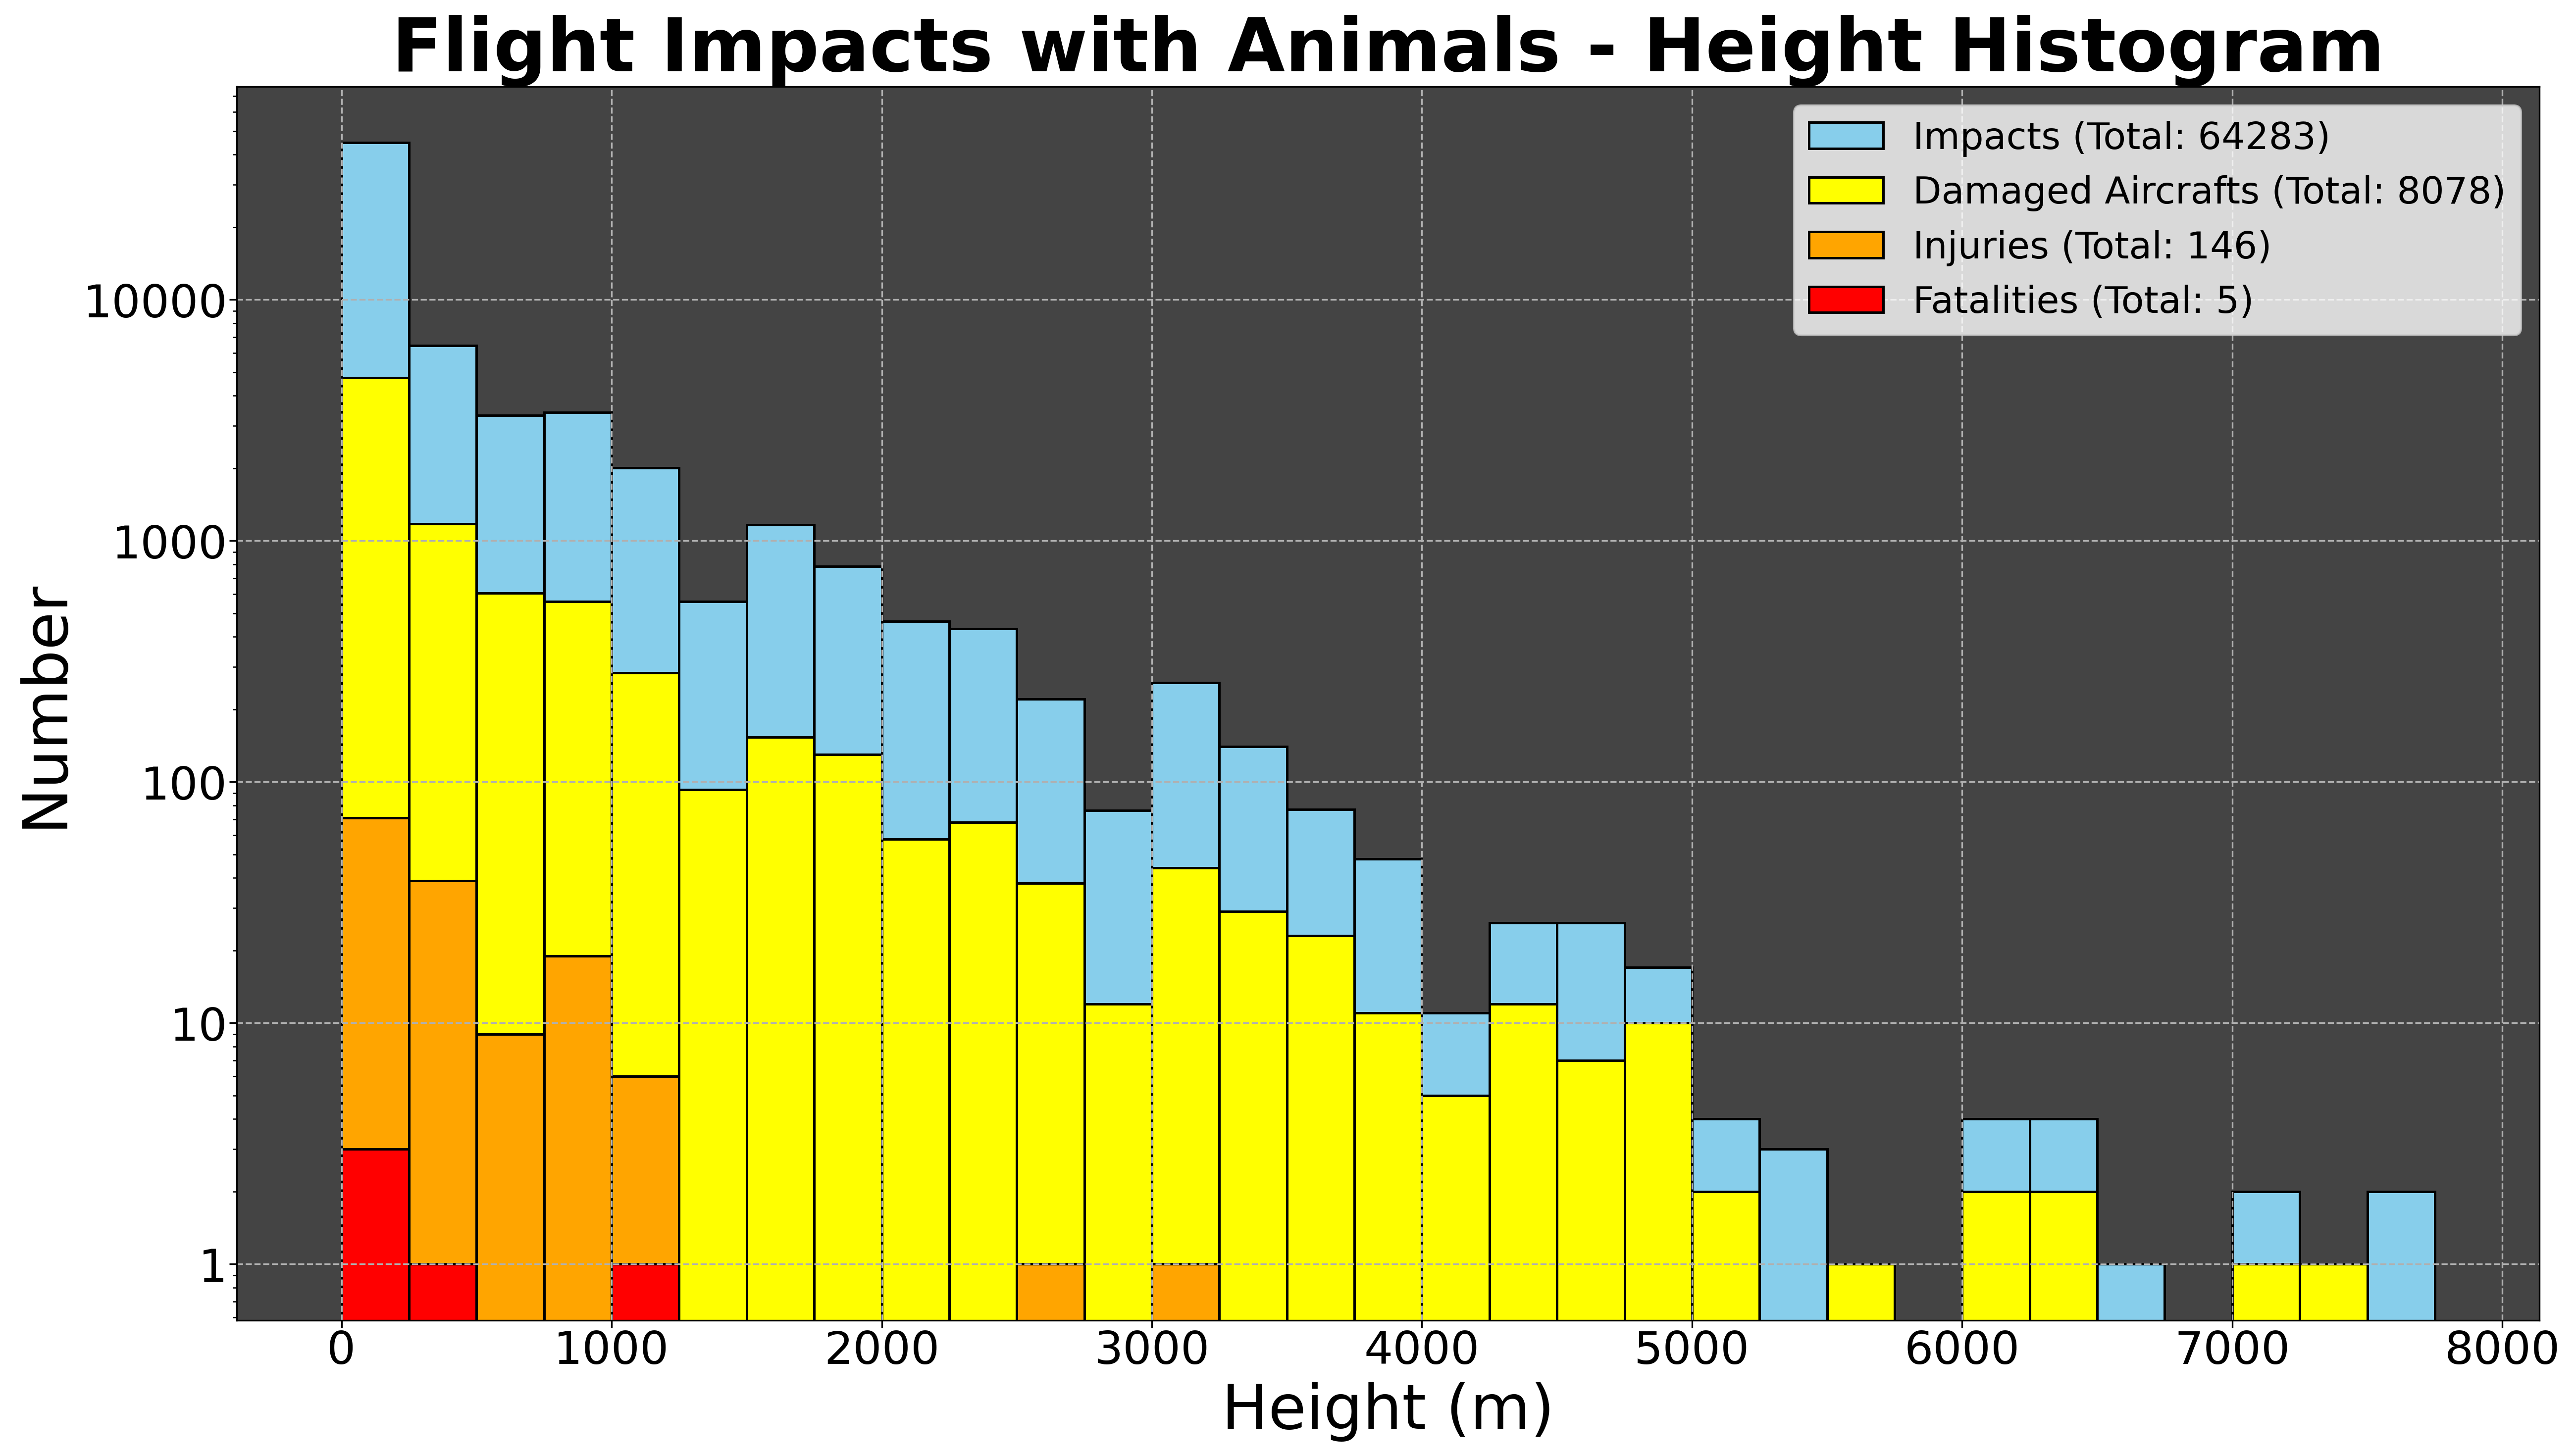

In [15]:
### Height Histogram

# Used to generate histograms for Height and Speed
def generateHistogram(col, units, binWidth):
    binMax = int(impacts[col].max()) + binWidth

    ax = plt.gca()
    fig = plt.gcf()
    ax.set_title(f"Flight Impacts with Animals - {col} Histogram", size=titleSize, fontweight='bold')
    fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
    plt.rcParams['axes.facecolor'] = backgroundColor
    plt.hist(impacts[col], bins=range(0, binMax, binWidth), label=impLabel, edgecolor='black',
             linewidth=1.2, color=impColor)
    plt.hist(impactsDmg[col], bins=range(0, binMax, binWidth), label=dmgLabel, edgecolor='black',
             linewidth=1.2, color=dmgColor)
    plt.hist(impactsInj[col], bins=range(0, binMax, binWidth), label=injLabel, edgecolor='black',
             linewidth=1.2, color=injColor)
    plt.hist(impactsFat[col], bins=range(0, binMax, binWidth), label=fatLabel, edgecolor='black',
             linewidth=1.2, color=fatColor)
    ax.set_yscale('log')
    plt.grid(axis='both', which="major", linestyle= '--')
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    plt.xlabel(f"{col} ({units})", size=axisLabelSize)
    plt.ylabel("Number", size=axisLabelSize)
    ax.tick_params(axis='both', which='major', pad=1, labelsize=tickLabelSize)
    fig.patch.set_facecolor('w')
    fig.set_dpi(DPI)

    if col == 'Speed':
        ax.axvspan(225, 300, alpha=0.5, color='lightgreen', label='Commercial Takeoff/Landing Speed')
    plt.legend(facecolor=legendColor, prop={'size': legendTextSize})
    
    plt.show()
    
generateHistogram('Height', 'm', 250)

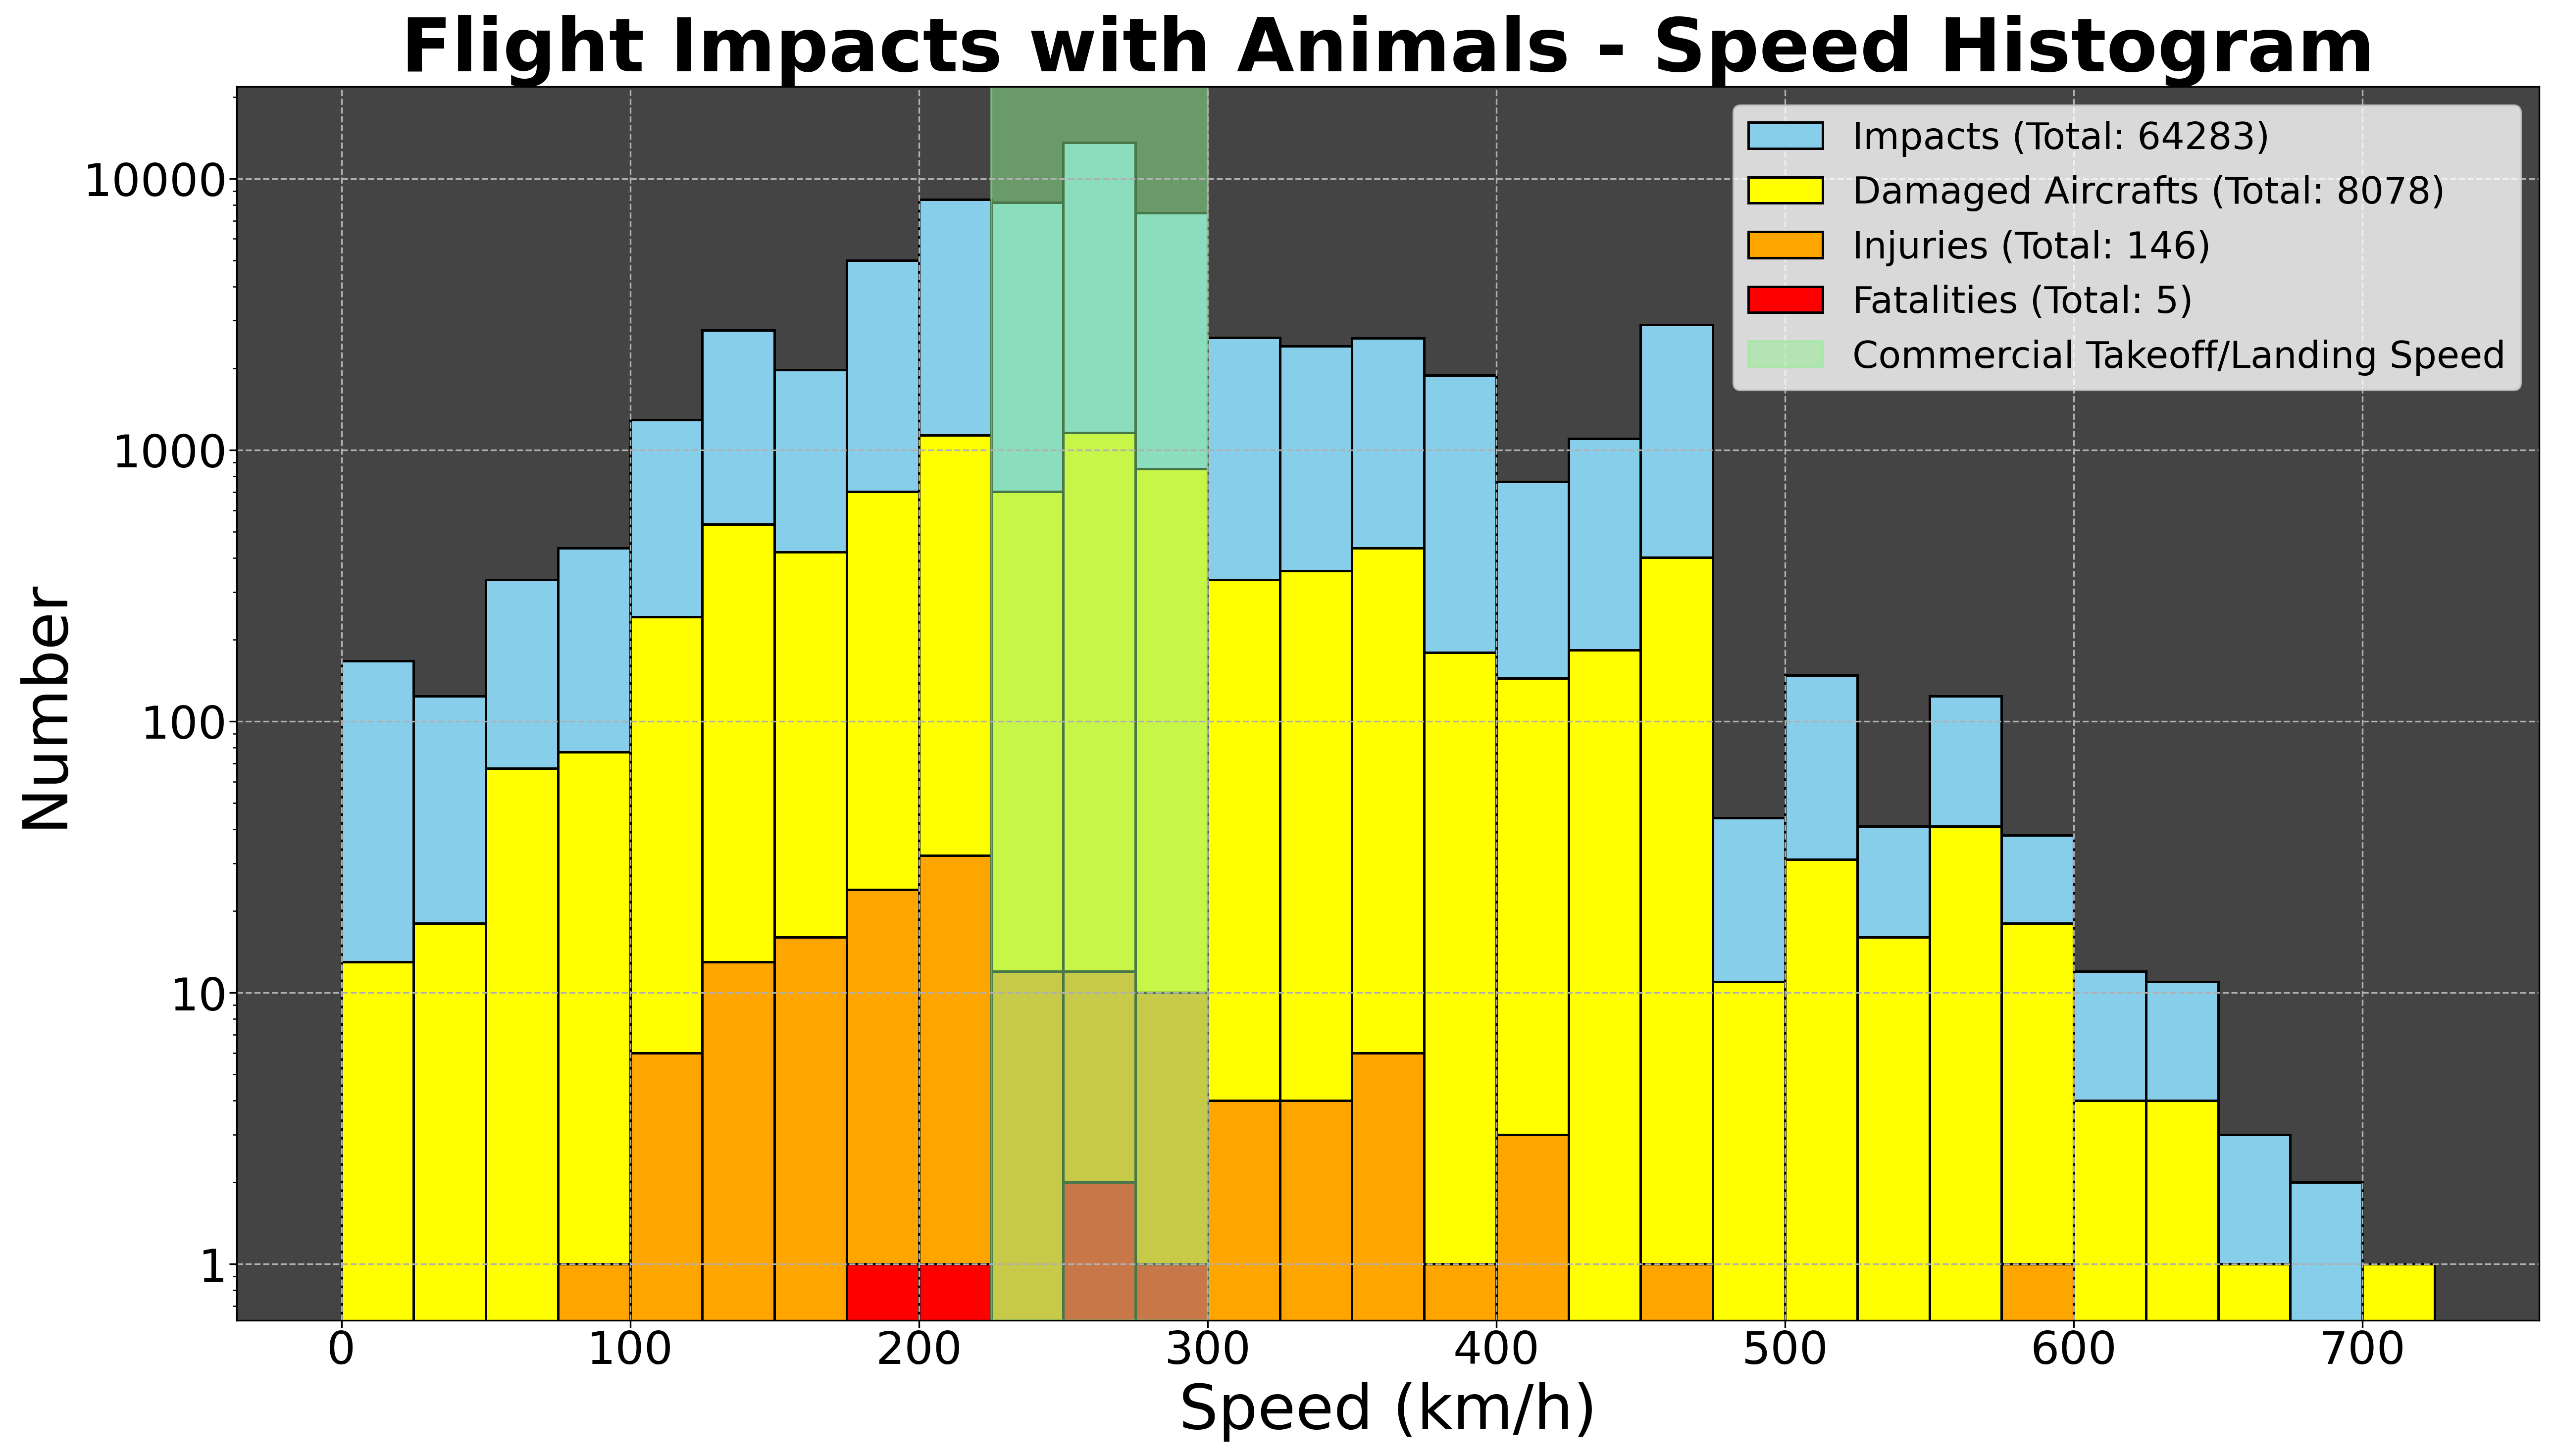

In [16]:
### Speed Histogram

generateHistogram('Speed', 'km/h', 25)

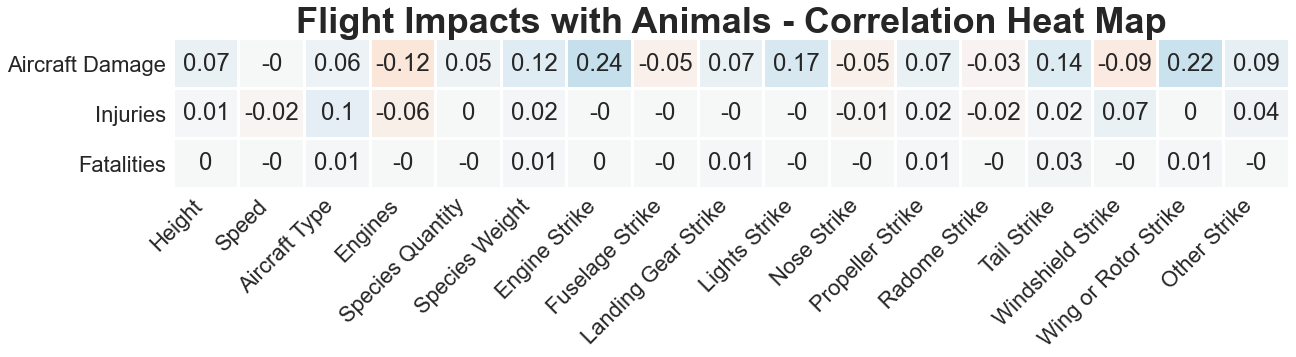

In [18]:
### Correlation Heat Map

impactsCorr = impacts.drop(['Biomass'], axis=1)
corr = impactsCorr.corr().round(2)
corr = corr.drop(predictionCols, axis=1)
corr = corr.drop(strikeLocations + ['Species Quantity', 'Engines', 'Height', 'Speed', 'Species Weight',
                                    'Aircraft Type'], axis=0)

sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap="RdBu", linewidths=2, cbar=False)
sns.set(rc={"figure.figsize":(standardCanvasWidth, standardCanvasHeight*0.25)})
sns.set(font_scale=2)
ax = plt.gca()
ax.set_title("Flight Impacts with Animals - Correlation Heat Map", size=titleSize, fontweight="bold")
ax.set_xticklabels(corr.columns, rotation = 45, ha="right")
ax.tick_params(axis='both', which='major', pad=1, labelsize=tickLabelSize)
fig.set_dpi(DPI)
plt.show()

In [193]:
### Generating and Saving Datamodels

cvGrid = {"n_estimators": [100, 250, 500],
          "max_depth": [5, 10, 20],
          "min_samples_split": [2, 4, 8],
          "min_samples_leaf": [1, 2, 4]}

cvGrid = {}

# Generates and saves a Random Forest Classifier model
def generateRFC(col):
    y = impacts.loc[:, col]
    X_train, X_test, y_train, y_test = train_test_split(impactsX_t, y, test_size=0.2)
    
    model = RandomizedSearchCV(RandomForestClassifier(), param_distributions=cvGrid, n_iter=1, cv=5, verbose=0)
    model.fit(X_train, y_train)
    scoreRFC = round(model.score(X_test, y_test), 6)
    pickle.dump(model, open(f"ByeByeBirdy_{col.replace(' ', '')}Model_{scoreRFC}.sav", 'wb'))
    print(f"{col} Model Score: {scoreRFC}")    

In [194]:
### Generating Models for Aircraft Damage

# generateRFC('Aircraft Damage')

Aircraft Damage Model Score: 0.90021


In [198]:
### Generating Models for Injuries

# generateRFC('Injuries')

Injuries Model Score: 0.998289


In [196]:
### Generating Models for Fatalities

# generateRFC('Fatalities')

Fatalities Model Score: 1.0


In [27]:
### Functions to Help Choose Inputs for Prediction

def printInputParams(aircraft, animal, quantity, height, speed):
    print(f"Aircraft: {aircraft}\nAnimal Species: {animal}\nNumber of Animals: {quantity}\n" +
          f"Height (m): {height}\nSpeed (km/h): {speed}")

# Help set up model predictions
def getPredRowStart(aircraft, animal, quantity, height, speed):
    X = impacts[['Aircraft','Aircraft Mass', 'Aircraft Type', 'Aircraft Make', 'Aircraft Model', 'Engines',
                 'Engine Type', 'Engine Make', 'Engine Model']][impacts['Aircraft'] == aircraft]
    X = pd.DataFrame(X.iloc[0]).transpose()

    X['Species Name'] = animal
    X['Species Weight'] = animalWeights[animal.replace(' ', '')]
    X['Species Quantity'] = quantity
    X['Height'] = height
    X['Speed'] = speed
    return X

# Get prediction results 
def getResultSummary(X, cols):
    X = X[XCols]
    X_t = transformer.fit_transform(X)
    
    resultSummary = pd.DataFrame(columns=cols)
    
    for col in predictionCols:
        if col == 'Aircraft Damage':
            model = pickle.load(open(f"ByeByeBirdy_AircraftDamageModel_0.90021.sav", 'rb'))
        if col == 'Injuries':
            model = pickle.load(open(f"ByeByeBirdy_InjuriesModel_0.998289.sav", 'rb'))
        if col == 'Fatalities':
            model = pickle.load(open(f"ByeByeBirdy_FatalitiesModel_1.0.sav", 'rb'))
        resultRow = [col] + list(model.predict_proba(X_t)[:, 1])
        resultSummary = resultSummary.append(pd.Series(resultRow, index=cols), ignore_index=True) 

    resultSummary = resultSummary.set_index('Prediction Type')
    resultSummary.index.name = None
    return resultSummary  

# Checks for easter egg conditions
def checkForEasterEggs(animal, quantity, height, speed):
    if height > 0:
        if animal == 'DEER': # Flying deer
            return 'Christmas is ruined!'
        elif animal == 'COW': # Flying cow
            return 'The cow jumped over the moon!'
    if speed > 3500: # World record aircraft speed
        if speed > 1.08e9: # Speed of light
            return 'You broke space, time, the universe, and everything!'
        return 'This is the fastest aircraft in history!'
    if height > 11280: # Highest flying bird ever recorded
        if height > 37650: # World record aircraft height
            if height > 188000: # Edge of atmosphere
                return 'This aircraft is a spacecraft!'
            return 'This is the highest flying aircraft in history!'
        return 'Birds do not fly this high you silly goose!'
    if quantity > 2.6e6: # Largest recorded bird flock
        return 'It is the BIRDPOCALYPSE!'
    return None
    
# Get predictions for an impact with the impact location(s) specified
def customImpactResult(aircraft, animal, quantity, height, speed, customImpacts):
    animal = animal.upper()
    
    easterEggPresent = checkForEasterEggs(animal, quantity, height, speed)
    if easterEggPresent is not None:
        return print(easterEggPresent)
        
    X = getPredRowStart(aircraft, animal, quantity, height, speed)
    
    for loc in customImpacts:
        X[loc] = customImpacts[loc]
    
    printInputParams(aircraft, animal, quantity, height, speed)
    return getResultSummary(X, ['Prediction Type', 'Probability'])

# Generate a table showing the prediction for each possible impact location (1 location per impact)
def impactStrikeTable(aircraft, animal, quantity, height, speed):
    animal = animal.upper()
    
    easterEggPresent = checkForEasterEggs(animal, quantity, height, speed)
    if easterEggPresent is not None:
        return print(easterEggPresent)
    
    X_common = getPredRowStart(aircraft, animal, quantity, height, speed)
    X = pd.DataFrame(columns=XCols)
    
    for i, strikeLocation in enumerate(strikeLocations):
        X_row = X_common.copy()
        X_row_strikes = [0] * len(strikeLocations)
        X_row_strikes[i] = 1
        X_row_strikes = pd.DataFrame([X_row_strikes], columns=strikeLocations)
        X_row = pd.concat([X_row.reset_index().drop(['index'], axis=1),
                           X_row_strikes.reset_index().drop(['index'], axis=1)], axis=1)
        X = pd.concat([X, X_row])
        
    resultSummaryCols = ['Prediction Type'] + strikeLocations
    printInputParams(aircraft, animal, quantity, height, speed)
    return getResultSummary(X, resultSummaryCols)

# Find the top "num" aircrafts with the specified stats
def findAircrafts(aircraft=None, make=None, model=None, mass=None, engines=None, eType=None, heli=None, num=5):
    if isinstance(mass, int):
        mass = str(mass)
        
    if isinstance(heli, bool):
        heli = int(heli)
    
    # Filtering
    aircraftTypes = impacts
    if (aircraft != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Aircraft'] == aircraft]
    if (make != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Aircraft Make'] == make]
    if (mass != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Aircraft Mass'] == mass]
    if (engines != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Engines'] == engines]
    if (eType != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Engine Type'] == eType]
    if (heli != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Aircraft Type'] == heli]
    
    if len(aircraftTypes) == 0:
        print('No matching aircrafts found...\n')
    else:
        print(str(aircraftTypes[['Aircraft', 'Aircraft Make', 'Aircraft Type', 'Aircraft Mass', 
                                 'Engines']].value_counts().nlargest(num)) + '\n')
        

In [35]:
### Info to help choose model inputs

print('Most Common Aircrafts (Filtered):')
findAircrafts(mass=1, heli=False)

print('Animals Stats:')
animalStats = pd.DataFrame.from_dict(animalWeights, orient='index')
animalStats['Species Name'] = impacts['Species Name'].str.replace(' ', '').value_counts()
animalStats = animalStats.rename(columns={0: "Weight (kg)", "Species Name": ""})
print(animalStats.sort_values("Weight (kg)", ascending=False))
print('\n')

print('Height and Speed Stats:')
impacts[['Height', 'Speed']].describe()


Most Common Aircrafts (Filtered):
Aircraft      Aircraft Make  Aircraft Type  Aircraft Mass  Engines
C-172         226            0              1              1.0        1156
PA-28         729            0              1              1.0         617
C-560         226            0              1              2.0         407
C-152         226            0              1              1.0         368
C-182 SKYLAN  226            0              1              1.0         196
dtype: int64

Animals Stats:
             Weight (kg)       
COW              910.000      4
DEER             110.000    988
TURKEY             6.750     96
PELICAN            6.100     56
EAGLE              4.610    130
CRANE              4.600     77
UNKLBRD            4.000   2019
GOOSE              4.000   1446
CORMORANT          2.675     46
OWL                2.019    932
VULTURE            1.500    788
HERON              1.500    523
OSPREY             1.400    109
FRIGATEBIRD        1.361     17
ANHINGA        

,Height,Speed
count,64283.000000,64283.000000
mean,319.505415,262.817996
std,594.167915,84.954684
min,0.000000,0.000000
25%,0.000000,222.240000
50%,45.719999,253.724000
75%,365.759988,296.320000
max,7619.999756,703.760000


In [28]:
### Predictions by Strike Location (1 strike location per impact)

impactStrikeTable(aircraft = 'C-172', 
                  animal ='Pelican', 
                  quantity = 2,
                  height = 0, # in m
                  speed = 275) # in km/h

Aircraft: C-172
Animal Species: PELICAN
Number of Animals: 2
Height (m): 0
Speed (km/h): 275


,Engine Strike,Fuselage Strike,Landing Gear Strike,Lights Strike,Nose Strike,Propeller Strike,Radome Strike,Tail Strike,Windshield Strike,Wing or Rotor Strike,Other Strike
Aircraft Damage,0.36,0.32,0.43,0.68,0.43,0.38,0.37,0.62,0.45,0.51,0.48
Injuries,0.04,0.06,0.04,0.04,0.02,0.05,0.06,0.06,0.23,0.13,0.04
Fatalities,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.00,0.01,0.03,0.01


In [33]:
### Predictions with Custom Strike Locations

# 1 for impact, 0 for no impact
impactLocs = {
    'Engine Strike': 1,
    'Fuselage Strike': 0,
    'Landing Gear Strike': 1,
    'Lights Strike': 0,
    'Nose Strike': 0,
    'Propeller Strike': 1,
    'Radome Strike': 0,
    'Tail Strike': 1,
    'Windshield Strike': 1,
    'Wing or Rotor Strike': 1,
    'Other Strike': 0
}

customImpactResult(aircraft='C-172', 
                   animal='Goose', 
                   quantity=11,
                   height=200, # in m
                   speed=400, # in km/h
                   customImpacts=impactLocs)

Aircraft: C-172
Animal Species: GOOSE
Number of Animals: 11
Height (m): 200
Speed (km/h): 400


,Probability
Aircraft Damage,0.74
Injuries,0.24
Fatalities,0.00
